# Ford GoBike System Data

_bike sharing report at Ford GoBike for February, 2019_

Having come to the close of Febraury, 2019. Ford GoBike Sharing System was able to record a total of 183,412 ( **one hundred and eighty thousand, four hundred and twelve** ) rides.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
df = pd.read_csv('dataset.csv')
df['end_time'] = pd.to_datetime(df['end_time'])
df['start_time'] = pd.to_datetime(df['start_time'])

## Demography

### Generation Class & Gender

Ford GoBike saw it's user to be **Millenials**, **Generation X**, **Generation Z**, **Baby Boomers** and **Silent Generation** cut across *Male*, *Female* and *Others* with Female Dominance amongst all generations. This shows that most users are Female

In [3]:
def segment_gen(birth_year:int) -> str:
    """Return the generation of a user given the birth year"""
    if birth_year < 1946:
        return "Silent Generation"
    
    elif birth_year >= 1946 and birth_year <= 1964:
        return "Baby Boomers"
    
    elif birth_year >= 1965 and birth_year <= 1980:
        return "Gen X"
    
    elif birth_year >= 1981 and birth_year <= 1996:
        return "Millenial"
    
    return "Gen Z"

def show_demography() -> None:
    """Shows the demography of users tracked for Ford GoBike System"""
    age_df = df[['member_birth_year', 'member_gender']].copy()
    age_df['generation'] = df['member_birth_year'].apply(segment_gen)
    generation_df = (
        age_df.drop('member_birth_year', axis=1)
        .groupby('generation').value_counts()
        .reset_index(name="gen_count")
    )
    
    plt.bar(generation_df.generation, generation_df.gen_count)
    plt.xlabel("Generation")
    plt.ylabel("Total")
    plt.title("Generation Demography")
    plt.xticks(rotation=15)

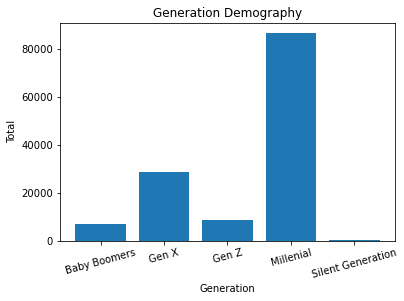

In [4]:
show_demography()

In [5]:
def show_gender_and_generation():
    age_df = df[['member_birth_year', 'member_gender']].copy()
    age_df['generation'] = df['member_birth_year'].apply(segment_gen)
    generation_df = (
        age_df.drop('member_birth_year', axis=1)
        .groupby('generation').value_counts()
        .reset_index(name="gen_count")
    )
    generation_df.pivot_table(['gen_count'], index=['generation'], dropna=True, columns=['member_gender']).plot(kind="bar")
    plt.xlabel("Generation and Gender")
    plt.ylabel("Total")
    plt.title("Generation Demography and Gender")
    plt.legend(['Male', 'Female', 'Other'], title="Member Gender")
    plt.xticks(rotation=15)

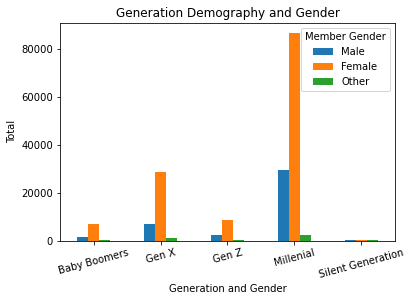

In [6]:
show_gender_and_generation()

### User Type

There existed just two targetted audience from the business model, *Subscriber Model* and *Customer Model*. For which majority of users are Male Millenials who are **Subscribers**

In [7]:
# retrieve data to compute the targeted member type
user_type_df = df[['member_birth_year', 'member_gender', 'user_type']].copy()
# remove those year with NaN values
user_type_df = user_type_df[user_type_df['member_birth_year'].isna() != True]
# segment user by their birth year into their different generations
user_type_df['generation'] = user_type_df['member_birth_year'].apply(segment_gen)

# Generating the total count of user type in a separate column type_count
user_type_count =  (
    user_type_df.drop('member_birth_year', axis=1)
    .groupby('user_type').value_counts()
    .reset_index(name="type_count")
)

def user_type_count_by_gender():
    """Plot graph for available user type aggregated by gender"""
    grouped_type_sex = user_type_count.groupby(['user_type', 'member_gender'])['type_count'].sum().reset_index(name="type_count")
    sb.barplot(data=grouped_type_sex, x='user_type', y='type_count', hue='member_gender')
    plt.xlabel("User Types")
    plt.ylabel("Count")
    plt.title("User Type Count By Gender")


def user_type_count_by_generation():
    grouped_type_gen = user_type_count.groupby(['user_type', 'generation'])['type_count'].sum().reset_index(name="type_count")
    sb.barplot(data=grouped_type_gen, x='user_type', y='type_count', hue='generation')
    plt.xlabel("User Types")
    plt.ylabel("Count")
    plt.title("User Type Count By Generation")   


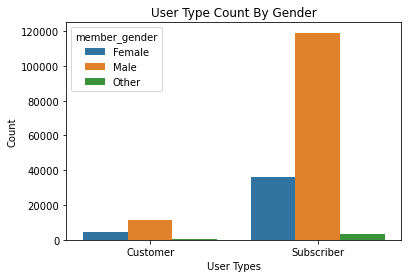

In [8]:
user_type_count_by_gender()

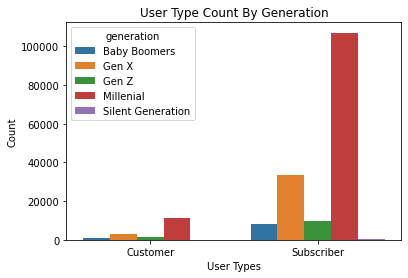

In [9]:
user_type_count_by_generation()

## Rides Recorded

It's interesting to see that the majority user base falls within the millenials (young adult) brackets. But how have they accepted the bike sharing system would be much more interesting. To figure this out, we'll look at

- How long an average trip take 
- Does duration depend on if a user is a subscriber or customer
- When are most trips taken in terms of time of day, day of the week, or month of the year
- Others

### How long does an average trip take ?

An average trip takes **726.1** seconds i.e approximately 12 minutes. Gender class of **Other** has the highest value of average duration in seconds, with **Female** holding first runner up and **Male** holding second runner up ( i.e Male have the lowest average time spent on rides )

In [10]:
df['duration_sec'].describe()

count    183412.000000
mean        726.078435
std        1794.389780
min          61.000000
25%         325.000000
50%         514.000000
75%         796.000000
max       85444.000000
Name: duration_sec, dtype: float64

In [11]:
def gender_average_ride_duration():
    duration_avg_by_gender_df = df.groupby('member_gender').mean()
    tx, texts = plt.pie(
        duration_avg_by_gender_df.duration_sec, 
        labels=duration_avg_by_gender_df.index, 
        counterclock=False, 
        textprops={"fontsize": 12, 'color': 'black'}
    )

    for i, a in enumerate(texts):
        a.set_text("{} ( {:.2f} )".format(duration_avg_by_gender_df.index[i], duration_avg_by_gender_df.duration_sec[i]))

    plt.legend(loc="center right",  bbox_to_anchor=(1.3, 0.5))
    plt.title("Average Duration By Gender on Rides");

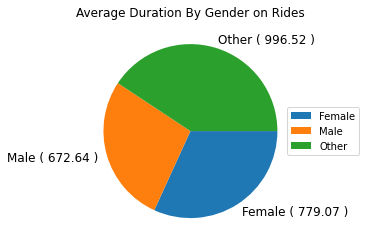

In [12]:
gender_average_ride_duration()

### when are most trips taken in terms of time of the day ?

Most trips are recorded late in the evening **17:02 pm** and early morning **08:02 am**

In [13]:
time_of_day_df = df[['start_time', 'end_time', 'duration_sec', 'user_type', 'bike_share_for_all_trip', 'bike_id']].copy()

# set start_time as the dataset index
time_df = (
    time_of_day_df.set_index("start_time")
    .to_period("H") # change index to be in period form holding hourly values
)

# set index to just hold the time of the day in format Hour:Minute
time_df.index = time_df.index.strftime("%H:%m")

def time_of_the_day_trip(df):
    # select a color to render each bars
    color_palette = sb.color_palette()[0]

    # plot hour with the most trip
    sb.countplot(x=df.index, color=color_palette)
    plt.xticks(rotation=90);
    plt.xlabel("Trip Start Time")
    plt.ylabel("Trip Recorded")
    plt.title("Hourly Total Trip");

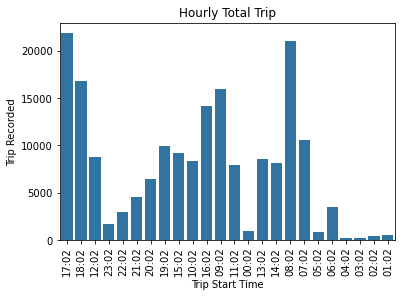

In [14]:
time_of_the_day_trip(time_df)

### when are most trips taken in terms of day of the week ?

Thursday clearly shows the day of the week with the most trip recorded. A  total of **35,000** recorded trips for thursday

In [15]:
def day_of_week_trip():
    week_day_trip_df = (
        df.set_index("start_time")
        .to_period("D")   # conversion to period is very important
    )

    # convert start time index to local weekday 
    week_day_trip_df.index = week_day_trip_df.index.strftime("%A")

    sb.countplot(x=week_day_trip_df.index, color=sb.color_palette()[0])
    plt.xticks(rotation=90);
    plt.xlabel("Week Day")
    plt.ylabel("Trip Recorded")
    plt.title("Week Day Total Trip");

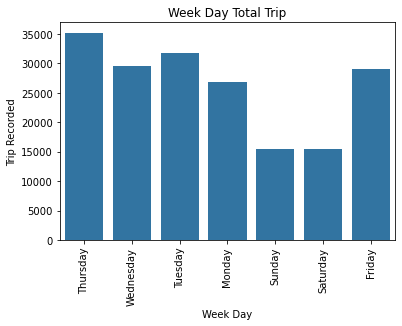

In [16]:
day_of_week_trip()

### when are most trips taken in terms of day of the week in respect to user type ?

_All trips recorded for Customer falls below 5,000 seconds for trip duration for all weekday with the highest being Thursday with 3,030 duration in seconds. Subscriber takes the highest duration with the maximum recorded trip duration seconds around 30,200 for thursday._

In [17]:
def daily_trip_duration_by_user_type():
    # group the dataset by user type and start time ( weekday equivalent )
    type_n_day_df = df[['start_time', 'user_type', 'duration_sec']].copy()
    # Convert start_time to week day 
    type_n_day_df['week_day'] = type_n_day_df['start_time'].apply(lambda x: x.strftime("%A"))
    # Group by user type and user type
    type_n_day_df = type_n_day_df.groupby(['user_type', 'week_day']).count().reset_index()

    week_day = pd.api.types.CategoricalDtype(
        categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    )
    type_n_day_df['week_day'] = type_n_day_df['week_day'].astype(week_day)

    # create a barplot mapping the dataset
    sb.barplot(data=type_n_day_df, x="week_day", y="duration_sec", hue="user_type")
    plt.xticks(rotation=90);
    plt.xlabel("Week Day")
    plt.ylabel("Duration (seconds)")
    plt.title("Daily Trip Duration By User Type");

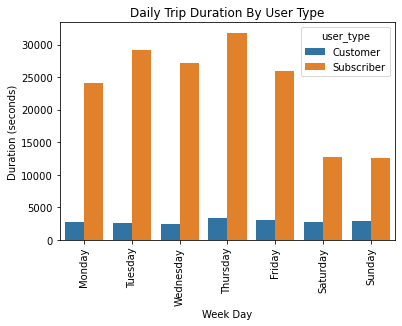

In [18]:
daily_trip_duration_by_user_type()

### when are most trips taken in terms of day of the week in respect to gender ?

While there seems to be consistent use (no increase nor decrease) of gender class **Other** for the same duration on a daily basis, there duration recorded for **Female** and **Male** gender class have variations with the highest duration recorded on **Thursday**

In [19]:
def daily_trip_duration_by_gender():
    # group the dataset by user type and start time ( weekday equivalent )
    gender_n_day_df = df[['start_time', 'member_gender', 'duration_sec']].copy()
    # Convert start_time to week day 
    gender_n_day_df['week_day'] = gender_n_day_df['start_time'].apply(lambda x: x.strftime("%A"))
    # Group by user type and gender
    gender_n_day_df = gender_n_day_df.groupby(['member_gender', 'week_day']).count().reset_index()

    week_day = pd.api.types.CategoricalDtype(
        categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    )
    gender_n_day_df['week_day'] = gender_n_day_df['week_day'].astype(week_day)

    # create a barplot mapping the dataset
    sb.barplot(data=gender_n_day_df, x="week_day", y="duration_sec", hue="member_gender")
    plt.xticks(rotation=90);
    plt.legend(bbox_to_anchor=(1.0, 0.5))
    plt.xlabel("Week Day")
    plt.ylabel("Duration (seconds)")
    plt.title("Daily Trip Duration By Gender");

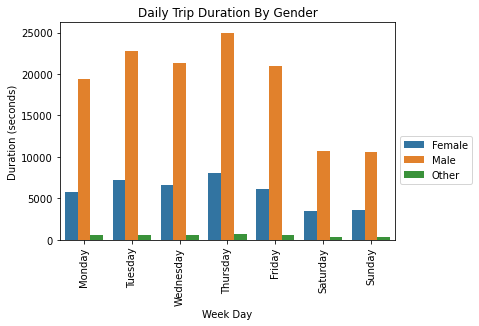

In [20]:
daily_trip_duration_by_gender()

### when are most trips taken in terms of time of the day for user type ?

In [21]:
def most_hourly_trip_for_user_type():
    new_time_df = time_df.reset_index()[['start_time', 'duration_sec', 'user_type']].copy()
    # Group by user_type and start_time and reset the aggregated count index ( so the index is not made of the grouped variable )
    grouped_time_df = new_time_df.groupby(['user_type', 'start_time']).count().reset_index()
    # map a barplot with the of the start time in comparison to the user type for the duration for each trip
    sb.barplot(data=grouped_time_df, x="start_time", hue="user_type", y="duration_sec")
    plt.xticks(rotation=90)
    plt.xlabel("Time")
    plt.ylabel("Duration (seconds)")
    plt.title("Hourly Trip Duration For User Type");

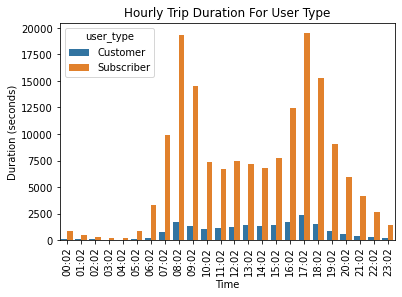

In [22]:
most_hourly_trip_for_user_type()

## Trips & Route Analysis

Could it be because there's traffic on Thursday and Tuesday hence why there's there's rise of ride duration (seconds) or could it be a causation by other factors ? 

According to the recorded rides, there are **329** trips/rides are started from. A prominent station is **Market St at 10th St** with **3904** rides started from it.

#### Categories of station by number of rides

**Market St at 10th St** according to the record is a high performing station. With this comes the question, how many high performing stations was tracked in records ?

A total of **175** of the stations rides were started from belonged to the **low** class who processed between **0-500 rides**

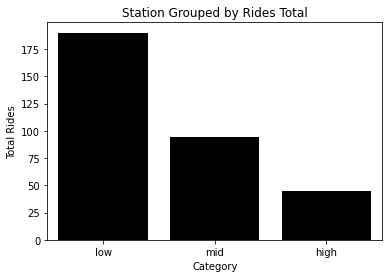

In [23]:
curiousity_df = df[['user_type', 'start_station_name', 'end_station_name', 'member_birth_year', 'member_gender', 'duration_sec']].copy()

cleaned_start_station_name_df = curiousity_df[curiousity_df['start_station_name'].isna() == False]
start_station_sized_count_df = cleaned_start_station_name_df.groupby('start_station_name').size().reset_index(name="count")

# group into counts into bins
bins = [0, 500, 1000, 5000]
labels = ['low', 'mid', 'high']
start_station_sized_count_df['tiers'] = pd.cut(x=start_station_sized_count_df['count'], bins=bins, labels=labels, include_lowest=True)

# check the tiers within which majority of the observations falls into
sb.countplot(x='tiers', data=start_station_sized_count_df, color='black')
plt.xlabel("Category")
plt.ylabel("Total Rides")
plt.title("Station Grouped by Rides Total");

#### TOP 10 Busiest Route

_**Berry St at 4th St to San Francisco Ferry Building (Harry Bridges Plaza)** is the busiest route with **337** rides recorded. This goes on to show that station where most rides is started from ( **Market St at 10th St** ) routes to diverse end location. Although this in turn didn't make it the first on the route mostly travelled, but it still made it to the top 10 appearing in 7th & 9th position_

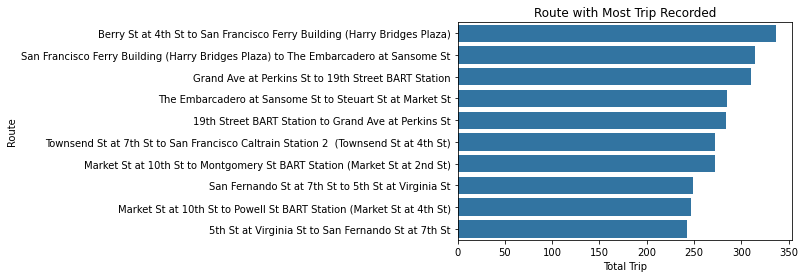

In [24]:
# create copy of the relevant variables to answer the question
routes_df = cleaned_start_station_name_df[['duration_sec', 'start_station_name', 'end_station_name']].copy()

# generate route variable
routes_df['route'] = routes_df['start_station_name'] + ' to ' + routes_df['end_station_name']

# Group by route column and count the unqiue rows in the dataframe
routes_df = routes_df.groupby('route').value_counts().reset_index(name="count").sort_values('count', ascending=False)

# get total trip completed for a route
total_route_trips_df = routes_df.groupby('route')['count'].sum().reset_index(name='total').sort_values('total', ascending=False)

# get the total duration in seconds for each route
total_route_trips_sec_df = routes_df.groupby('route')['duration_sec'].sum().reset_index(name='total_sec').sort_values('total_sec', ascending=False)

# drop 'duration in second' 'count', and 'station start & end name' as they've completed their desired tasks
routes_df = routes_df.drop(['duration_sec', 'count', 'start_station_name', 'end_station_name'], axis=1).drop_duplicates()

# merge total trips to routes dataframe
routes_df = routes_df.merge(total_route_trips_df, on="route", how='inner')

# merge total duration in seconds routes dataframe
routes_df = routes_df.merge(total_route_trips_sec_df, on='route', how='inner')

# First 10 routes 
top_ten = routes_df.sort_values('total', ascending=False)[:10]

sb.barplot(data=top_ten, y='route', x='total', color=sb.color_palette()[0], ci=60)
plt.xlabel("Total Trip")
plt.ylabel("Route")
plt.title("Route with Most Trip Recorded");

##### does being the busiest correlates with the total duration spent on a trip ?

_the more duration spent on a trip has a steep measure on the total number of trip done for a given trip route. That is to say, majority of the trip takes lesser duration to complete and an aggregate of them doesn't amount much on the duration_

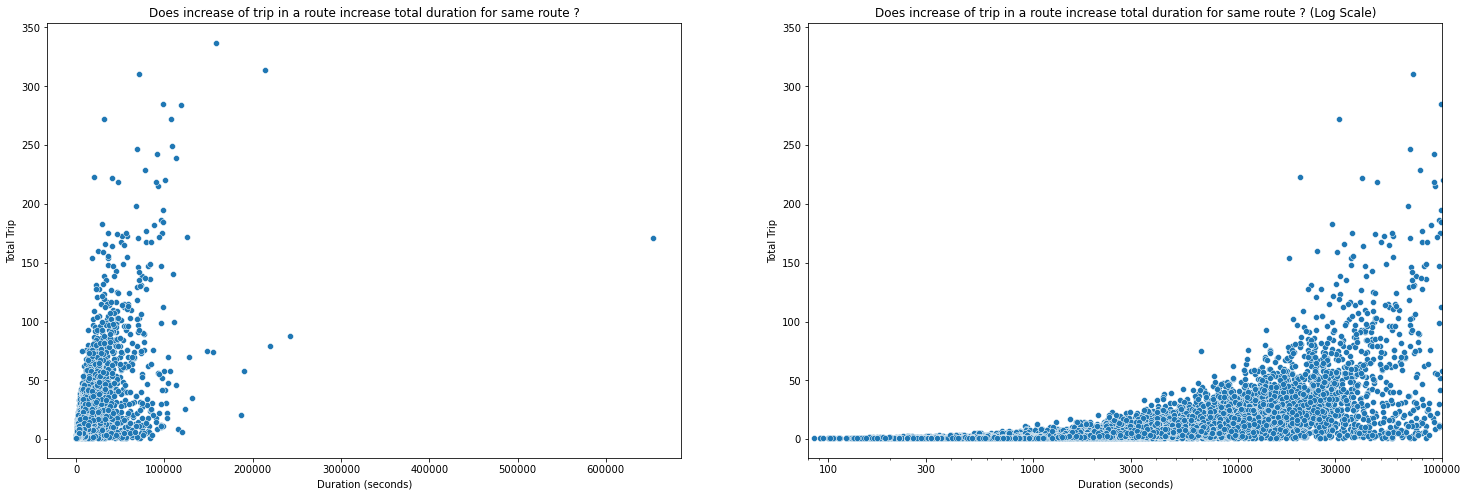

In [25]:
plt.figure(figsize=[25, 8])

plt.subplot(1, 2, 1)
sb.scatterplot(x=routes_df.total_sec, y=routes_df.total)
plt.title('Does increase of trip in a route increase total duration for same route ?')
plt.ylabel('Total Trip')
plt.xlabel('Duration (seconds)')

plt.subplot(1, 2, 2)
sb.scatterplot(x=routes_df.total_sec, y=routes_df.total)
plt.title('Does increase of trip in a route increase total duration for same route ? (Log Scale)')
plt.xscale('log')
ticks = [100, 300, 1000, 3000, 10000, 30000, 100000, 300000]
plt.xticks(ticks, ticks)
plt.xlim(80, 100000)
plt.ylabel('Total Trip')
plt.xlabel('Duration (seconds)');

## Conclusion

The records has shown that the demography of Ford GoBike Sharing falls within **Millenials**.

Some suggestion to improving on the ride sharing system as it relates to the questions that the current data poses are :

**How we improve ride duration** ?

- Suggest other routes to users

**How can we do more numbers** ?

- Increase number of bikes in hot zones e.g **Market St at 10th St** ( TODO:: explore bike variable to get insight on this )
- Users engagement users on other week days as most records currently only happens on Tuesday and Thursdays at specific time


Overall, the trajectory looks stable and with the coming month data, much more insight would be gotten to the behavior of users 